# 고정비율+평균모멘텀스코어 그림 3-17
- 주식에 투자할 고정비율을 정함 : 25%
- 매월 말 코스피지수의 12개월 평균 모멘텀 스코어를 구한다.
- 미리 정해놓은 고정비율(25%)와 평균 모멘텀 스코어를 곱한 비율이 주식투자비율, 나머지가 현금비율
- 매월 말 이 비율을 계산하여 리밸런싱한다
  - 코스피 고정 투자 비율 25%, 코스피 평균 모멘텀 스코어 0.5 인 경우
- 주식투자비율 = 25% x 0.5 = 12.5%,
- 현금 투자비율 = 100% - 12.5% = 87.5%
- 현금비율 추가하면 (1:1로 섞기 때문에 나누기 2를 해준다.)
    - 주식투자비율 : 25%(고정비율) x 0.5(평균모멘텀스코어) x 현금비율/2  
    - 현금투자비율 : 1 - 주식투자비율

In [1]:
from settings import *

In [2]:
kospi = fdr.DataReader('KS11')[['Close']]

In [3]:
kospi

,Close
Date,
1981-05-01,123.600
1981-05-02,123.500
1981-05-04,120.600
1981-05-06,120.700
1981-05-07,119.300
...,...
2022-02-17,2744.090
2022-02-18,2744.520
2022-02-21,2743.800


In [4]:
kospi['1981-5'].tail()

,Close
Date,
1981-05-26,123.000
1981-05-27,124.800
1981-05-28,125.900
1981-05-29,126.500
1981-05-30,126.300


In [5]:
kospi['2021-12'].tail()

,Close
Date,
2021-12-24,3012.430
2021-12-27,2999.550
2021-12-28,3020.240
2021-12-29,2993.290
2021-12-30,2977.650


In [6]:
s = '1981-5-29'
e = '2021-12-30'

In [7]:
data = pd.DataFrame()
data['KOSPI'] = kospi.copy()
data = data[s:e]

In [8]:
dd = pd.DataFrame()
dd.index = pd.date_range(s, e, freq='D')
denominator = len(pd.date_range(s, e, freq='D'))/len(pd.date_range(s, e, freq='Y'))
dd['현금'] = pow(1.03, 1/denominator)
dd['현금'] = dd['현금'].shift(1, fill_value=1.0)
dd['현금'] = dd['현금'].cumprod()
#%%
data = pd.merge(data, dd, left_index=True, right_index=True, how='left')

In [9]:
data

,KOSPI,현금
Date,,
1981-05-29,126.500,1.000
1981-05-30,126.300,1.000
1981-06-01,126.400,1.000
1981-06-02,127.700,1.000
1981-06-03,129.800,1.000
...,...,...
2021-12-24,3012.430,3.260
2021-12-27,2999.550,3.261
2021-12-28,3020.240,3.261


## WeighFixedRateAverageMomentumScore

In [10]:
# - 주식에 투자할 고정비율을 정함 : 25%
# - 매월 말 코스피지수의 12개월 평균 모멘텀 스코어를 구한다.
# - 미리 정해놓은 고정비율(25%)와 평균 모멘텀 스코어를 곱한 비율이 주식투자비율, 나머지가 현금비율
# - 매월 말 이 비율을 계산하여 리밸런싱한다
#   - 코스피 고정 투자 비율 25%, 코스피 평균 모멘텀 스코어 0.5 인 경우
# - 주식투자비율 = 25% x 0.5 = 12.5%,
# - 현금 투자비율 = 100% - 12.5% = 87.5%
# - 현금비율 추가하면 (1:1로 섞기 때문에 나누기 2를 해준다.)
#     - 주식투자비율 : 25%(고정비율) x 0.5(평균모멘텀스코어) x 현금비율/2  
#     - 현금투자비율 : 1 - 주식투자비율
class WeighFixedRateAverageMomentumScore(bt.Algo):
    def __init__(self, months=12, lag=pd.DateOffset(days=0), fixed_rate=0.25, 
                 cash='현금', cash_weigh=0.0, 현금자산제외=True):
        """ 고정비율*평균모멘텀스코어 비율 만큼 투자
        
            months : 모멘텀스코어 계산하는 개월수
            lag : 현재에서 얼마만큼 lag를 줄 것인지 결정
            fixed_rate : 주식에 투자할 고정 비율
            cash : cash자산 이름(기본값: 현금)
            cash_weigh : 현금비중 (기본값: 0 -> 고려하지 않음), 현금비중 올라감
            현금자산제외 : 모멘텀스코어 계산시 현금을 하나의 자산으로 취급할지를 결정 (기본값 : True)
                        False인 경우 현금을 하나의 자산으로 취급하면 그만큼 현금비중이 올라감
        """
        super(WeighFixedRateAverageMomentumScore, self).__init__()
        self.lookback = months
        self.lag = lag
        self.fixed_rate = fixed_rate
        self.cash = cash
        self.cash_weigh = cash_weigh
        self.현금자산제외 = 현금자산제외

    def __call__(self, target):
        selected = target.temp['selected'].copy()

        if self.현금자산제외: # 현금자산빼고 모멘텀 비중나누고 나머지는 현금으로 , 아니면 현금도 하나의 자산으로
            selected.remove(self.cash)

        t0 = target.now - self.lag

        if target.universe[selected].index[0] > (t0 - pd.DateOffset(months=self.lookback)): # !!!
            return False

        momentums_score = 0
        for lookback in range(1, self.lookback+1):
            start = t0 - pd.DateOffset(months=lookback)
            prc = target.universe[selected].loc[start:t0]
            momentum_score = np.where(prc.calc_total_return() > 0, 1, 0)
            momentums_score += momentum_score

        average_momentum_score = momentums_score / self.lookback
#         print(average_momentum_score)

        average_momentum_score *= (1 - self.cash_weigh)
        
        # XXX systrader79/backtesting/ebook/dynamic/10.mxied_korea_us.py 수정필요
        if self.현금자산제외: ## XXX 이 로직이 맞는지 모르겠음
            weights = average_momentum_score/len(selected)
            weights *= self.fixed_rate #!!!! 추가
            weights = pd.Series(weights, index=selected)
            weights[self.cash] = 1-weights.sum()
        else:
            weights = average_momentum_score/average_momentum_score.sum()
            weights = pd.Series(weights, index=selected)


        target.temp['weights'] = weights

        return True

In [11]:
def average_momentum_score_fixed_rate(name, data, months=12, lag=pd.DateOffset(days=0), 
                                        fixed_rate=0.25, cash='현금', 현금자산제외=False):
    st = bt.Strategy(name,
        [
            bt.algos.RunMonthly(run_on_first_date=True,
                                run_on_end_of_period=True, #월말
                                run_on_last_date=False),
            bt.algos.SelectAll(),
            WeighFixedRateAverageMomentumScore(months, lag, fixed_rate,
                                               cash, 0,  현금자산제외),
            PrintTempWeights(),
            bt.algos.Rebalance()
        ]
    )
    return bt.Backtest(st, data, initial_capital=100000000)

In [12]:
data

,KOSPI,현금
Date,,
1981-05-29,126.500,1.000
1981-05-30,126.300,1.000
1981-06-01,126.400,1.000
1981-06-02,127.700,1.000
1981-06-03,129.800,1.000
...,...,...
2021-12-24,3012.430,3.260
2021-12-27,2999.550,3.261
2021-12-28,3020.240,3.261


In [13]:
bt_fr = average_momentum_score_fixed_rate("고정비율+모멘텀", data, 12, pd.DateOffset(days=1), 
                                            0.25, '현금', 현금자산제외=True)
r_fr = bt.run(bt_fr)

1982-05-31 00:00:00 고정비율+모멘텀 KOSPI:0.000 현금:1.000 
1982-06-30 00:00:00 고정비율+모멘텀 KOSPI:0.083 현금:0.917 
1982-07-31 00:00:00 고정비율+모멘텀 KOSPI:0.104 현금:0.896 
1982-08-31 00:00:00 고정비율+모멘텀 KOSPI:0.062 현금:0.938 
1982-09-30 00:00:00 고정비율+모멘텀 KOSPI:0.021 현금:0.979 
1982-10-30 00:00:00 고정비율+모멘텀 KOSPI:0.021 현금:0.979 
1982-11-30 00:00:00 고정비율+모멘텀 KOSPI:0.146 현금:0.854 
1982-12-24 00:00:00 고정비율+모멘텀 KOSPI:0.208 현금:0.792 
1983-01-31 00:00:00 고정비율+모멘텀 KOSPI:0.021 현금:0.979 
1983-02-28 00:00:00 고정비율+모멘텀 KOSPI:0.208 현금:0.792 
1983-03-31 00:00:00 고정비율+모멘텀 KOSPI:0.042 현금:0.958 
1983-04-30 00:00:00 고정비율+모멘텀 KOSPI:0.250 현금:0.750 
1983-05-31 00:00:00 고정비율+모멘텀 KOSPI:0.229 현금:0.771 
1983-06-30 00:00:00 고정비율+모멘텀 KOSPI:0.125 현금:0.875 
1983-07-30 00:00:00 고정비율+모멘텀 KOSPI:0.208 현금:0.792 
1983-08-31 00:00:00 고정비율+모멘텀 KOSPI:0.021 현금:0.979 
1983-09-30 00:00:00 고정비율+모멘텀 KOSPI:0.000 현금:1.000 
1983-10-31 00:00:00 고정비율+모멘텀 KOSPI:0.083 현금:0.917 
1983-11-30 00:00:00 고정비율+모멘텀 KOSPI:0.021 현금:0.979 
1983-12-24 00:00:00 고정비율+모멘텀 KO

In [14]:
start = '1982-05-31'

In [15]:
r_fr.set_date_range(start)
r_fr.display()

Stat                 고정비율+모멘텀
-------------------  -----------------
Start                1982-05-31
End                  2021-12-30
Risk-free rate       0.00%

Total Return         523.62%
Daily Sharpe         1.26
Daily Sortino        2.03
CAGR                 4.73%
Max Drawdown         -6.46%
Calmar Ratio         0.73

MTD                  0.43%
3m                   0.13%
6m                   -0.72%
YTD                  3.88%
1Y                   3.88%
3Y (ann.)            4.72%
5Y (ann.)            4.38%
10Y (ann.)           3.17%
Since Incep. (ann.)  4.73%

Daily Sharpe         1.26
Daily Sortino        2.03
Daily Mean (ann.)    4.44%
Daily Vol (ann.)     3.51%
Daily Skew           -0.10
Daily Kurt           8.64
Best Day             1.93%
Worst Day            -1.97%

Monthly Sharpe       1.19
Monthly Sortino      2.95
Monthly Mean (ann.)  4.71%
Monthly Vol (ann.)   3.96%
Monthly Skew         1.15
Monthly Kurt         3.59
Best Month           5.58%
Worst Month          -2.78%

Ye

In [16]:
r_fr.prices.resample('M').last().to_drawdown_series().min()*100

고정비율+모멘텀   -5.161
dtype: float64

In [17]:
def strategy_static(name, data, stock_w, cash_w):
    s = bt.Strategy(name, 
            [
                bt.algos.RunMonthly(run_on_end_of_period=True),
                bt.algos.SelectAll(),
                bt.algos.WeighSpecified(KOSPI=stock_w, 현금=cash_w),
                PrintTempWeights(),
                bt.algos.Rebalance(),
                # bt.algos.PrintInfo('{now} {name} {_price} {temp} \n{_universe}')
            ])

    return bt.Backtest(s, data, initial_capital=100000000.0)

In [18]:
t고정비율 = strategy_static("고정비율", data, 0.25, 0.75)

In [19]:
r고정비율 = bt.run(t고정비율)

1981-05-29 00:00:00 고정비율 KOSPI:0.250 현금:0.750 
1981-05-30 00:00:00 고정비율 KOSPI:0.250 현금:0.750 
1981-06-30 00:00:00 고정비율 KOSPI:0.250 현금:0.750 
1981-07-31 00:00:00 고정비율 KOSPI:0.250 현금:0.750 
1981-08-31 00:00:00 고정비율 KOSPI:0.250 현금:0.750 
1981-09-30 00:00:00 고정비율 KOSPI:0.250 현금:0.750 
1981-10-31 00:00:00 고정비율 KOSPI:0.250 현금:0.750 
1981-11-30 00:00:00 고정비율 KOSPI:0.250 현금:0.750 
1981-12-24 00:00:00 고정비율 KOSPI:0.250 현금:0.750 
1982-01-30 00:00:00 고정비율 KOSPI:0.250 현금:0.750 
1982-02-27 00:00:00 고정비율 KOSPI:0.250 현금:0.750 
1982-03-31 00:00:00 고정비율 KOSPI:0.250 현금:0.750 
1982-04-30 00:00:00 고정비율 KOSPI:0.250 현금:0.750 
1982-05-31 00:00:00 고정비율 KOSPI:0.250 현금:0.750 
1982-06-30 00:00:00 고정비율 KOSPI:0.250 현금:0.750 
1982-07-31 00:00:00 고정비율 KOSPI:0.250 현금:0.750 
1982-08-31 00:00:00 고정비율 KOSPI:0.250 현금:0.750 
1982-09-30 00:00:00 고정비율 KOSPI:0.250 현금:0.750 
1982-10-30 00:00:00 고정비율 KOSPI:0.250 현금:0.750 
1982-11-30 00:00:00 고정비율 KOSPI:0.250 현금:0.750 
1982-12-24 00:00:00 고정비율 KOSPI:0.250 현금:0.750 
1983-01-31 00

In [20]:
r_all = bt.run(bt_fr, t고정비율)

In [21]:
end = e

In [22]:
r_all.set_date_range(start, end)
r_all.display()

Stat                 고정비율+모멘텀    고정비율
-------------------  -----------------  ----------
Start                1982-05-31         1982-05-31
End                  2021-12-30         2021-12-30
Risk-free rate       0.00%              0.00%

Total Return         523.62%            581.87%
Daily Sharpe         1.26               0.82
Daily Sortino        2.03               1.35
CAGR                 4.73%              4.97%
Max Drawdown         -6.46%             -20.05%
Calmar Ratio         0.73               0.25

MTD                  0.43%              1.40%
3m                   0.13%              -0.16%
6m                   -0.72%             -1.36%
YTD                  3.88%              3.23%
1Y                   3.88%              3.23%
3Y (ann.)            4.72%              5.96%
5Y (ann.)            4.38%              4.48%
10Y (ann.)           3.17%              3.65%
Since Incep. (ann.)  4.73%              4.97%

Daily Sharpe         1.26               0.82
Daily Sortino        2

In [23]:
r_all.prices.resample('M').last().to_drawdown_series().min()

고정비율+모멘텀   -0.052
고정비율       -0.187
dtype: float64

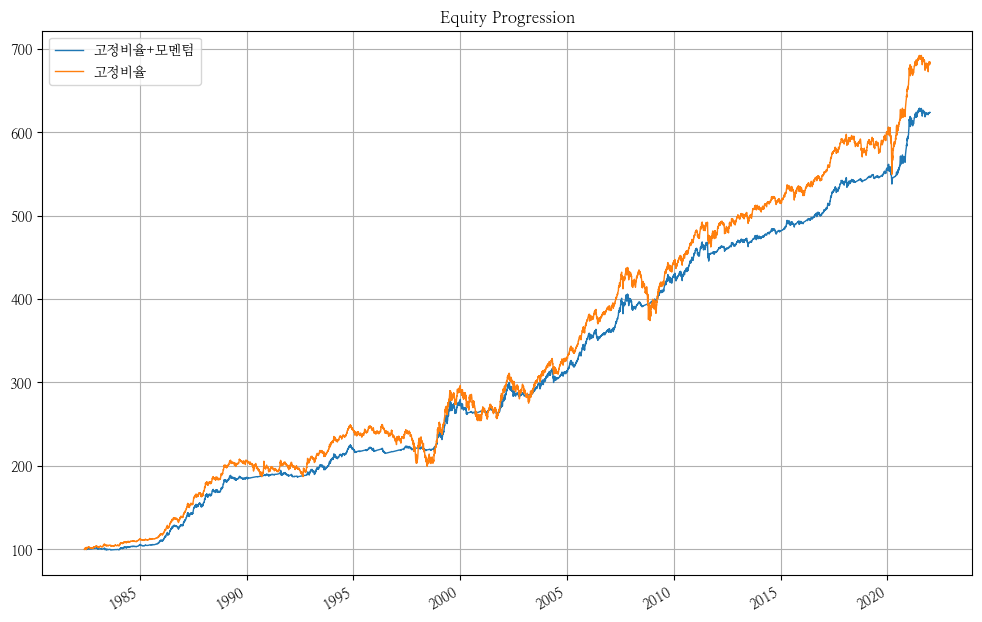

In [24]:
r_all.plot(figsize=(12,8));

          CAGR
고정비율+모멘텀 4.733
고정비율     4.969
             MDD
고정비율+모멘텀  -6.458
고정비율     -20.053


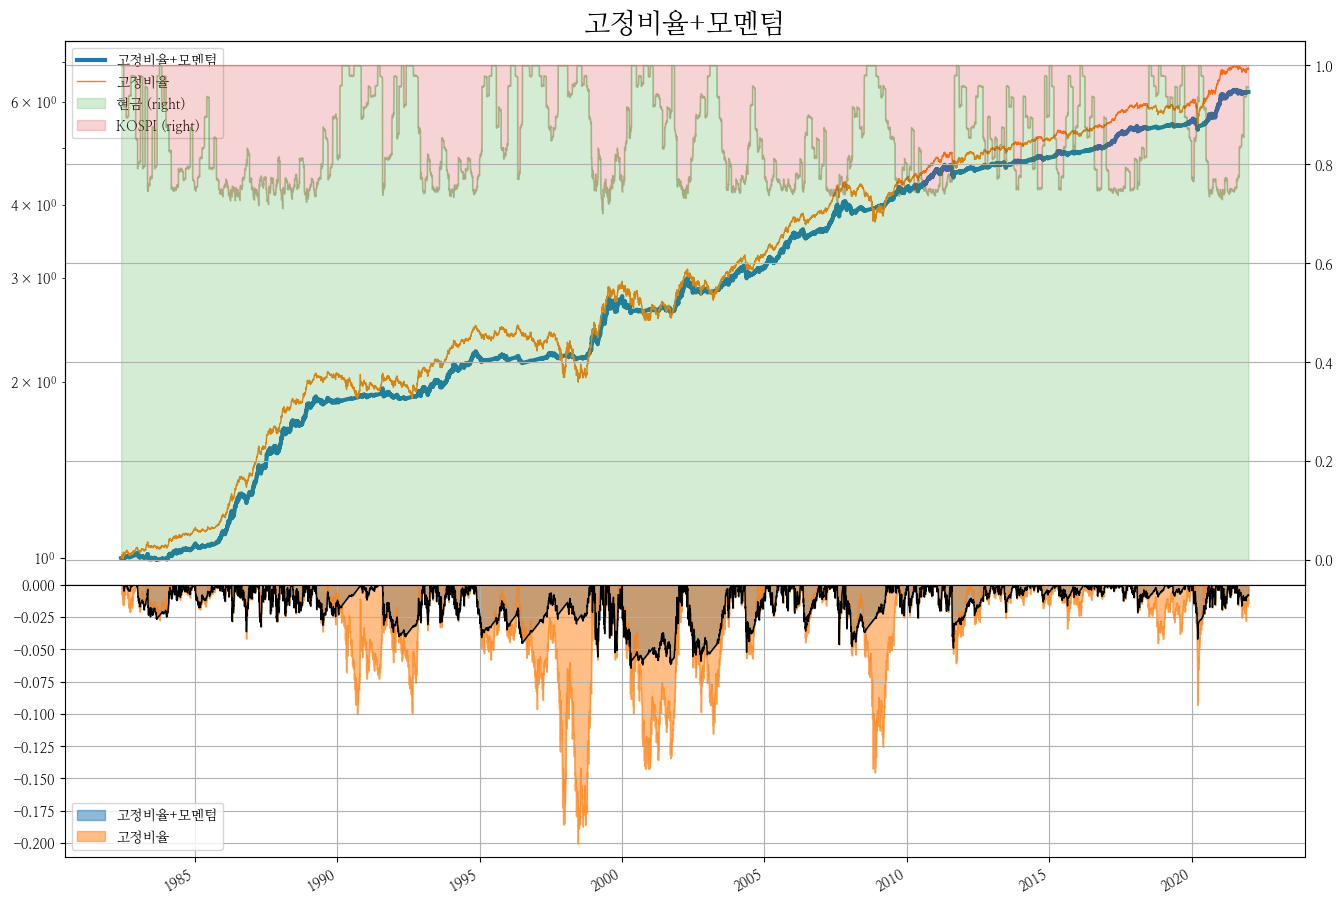

In [25]:
plot_assets(r_all, start, end, '고정비율+모멘텀')